# Zeroshot Polymer DNN Model

This notebook implements a zeroshot Deep Neural Network (DNN) model for polymer toxicity prediction using PyTorch and Optuna for hyperparameter optimization. It leverages transfer learning from the Tox21 dataset to predict polymer toxicity, specifically using the last 28 entries as the polymer/monomer dataset for Zero-shot learning and validation.


## 1. GPU Avaibilty Check

In [1]:
import os
import subprocess
import torch

def get_filtered_free_gpus(allowed_gpus={0, 2, 3}):
    """Return (gpu_id, free_mem_MB) from allowed_gpus, sorted by free memory."""
    try:
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=index,memory.free', '--format=csv,noheader,nounits'],
            encoding='utf-8'
        )
        gpu_info = []
        for line in result.strip().split('\n'):
            gpu_id, mem_free = line.strip().split(',')
            gpu_id = int(gpu_id)
            mem_free = int(mem_free)
            if gpu_id in allowed_gpus:
                gpu_info.append((gpu_id, mem_free))
        return sorted(gpu_info, key=lambda x: x[1], reverse=True)
    except Exception as e:
        print("⚠️ Could not query GPU info:", e)
        return []

# Step 1: Get preferred GPU (among 0, 2, 3)
available_gpus = get_filtered_free_gpus()

if available_gpus:
    selected_system_gpu = available_gpus[0][0]
    os.environ["CUDA_VISIBLE_DEVICES"] = str(selected_system_gpu)
    print(f"🧠 Selected system GPU ID: {selected_system_gpu} with {available_gpus[0][1]} MB free memory.")
else:
    print("⚠️ No preferred GPUs available. Using CPU.")

# Step 2: PyTorch setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    visible_device_name = torch.cuda.get_device_name(current_device)
    visible_ids = os.environ["CUDA_VISIBLE_DEVICES"].split(",")
    real_system_gpu_id = visible_ids[current_device]

    print("✅ GPU is available!")
    print(f"🖥️ Visible PyTorch Device: cuda:{current_device}")
    print(f"🧭 Actual system GPU ID: {real_system_gpu_id}")
    print(f"📟 GPU Name: {visible_device_name}")
else:
    print("⚠️ GPU not available. Using CPU.")

print(f"Model will run on: {device}")



🧠 Selected system GPU ID: 2 with 40323 MB free memory.
✅ GPU is available!
🖥️ Visible PyTorch Device: cuda:0
🧭 Actual system GPU ID: 2
📟 GPU Name: NVIDIA A100-SXM4-40GB
Model will run on: cuda


In [2]:
import os
print("My PID:", os.getpid())


My PID: 3888580


## 2. # IMPORTS AND GLOBAL CONFIGURATIONS

In [19]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("Libraries imported and random seed set.")

Libraries imported and random seed set.


#  CONFIGURATION AND PATHS FOR ZERO-SHOT ---

In [4]:
# --- 1. CONFIGURATION AND PATHS FOR ZERO-SHOT ---

# Paths provided by you
BASE_MODEL_PATH = "/home/sunil/am2/poetry-demo/Polytox_Matser_Thesis/Few_shot_learning_with_validation_data_Monomers/Zeroshot_DNN_Model_2/models/base_model.pt"
PARAMS_PATH = "/home/sunil/am2/poetry-demo/Polytox_Matser_Thesis/Few_shot_learning_with_validation_data_Monomers/Zeroshot_DNN_Model_2/optuna_results/best_params.json"
POLYMER_DATA_PATH = "/home/sunil/am2/poetry-demo/Polytox_Matser_Thesis/Few_shot_learning_with_validation_data_Monomers/Zeroshot_DNN_Model_2/polymer_DNN_encoded_final_data.csv"

# Directory to save new results
RESULTS_DIR = "./results_zeroshot"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Define class names for plotting and reports
class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']

print("Configuration for Zero-Shot evaluation is set.")

Configuration for Zero-Shot evaluation is set.


## 2. DEFINE YOUR DNN MODEL CLASS(ToxiciityDNN CLASS DEFINITION )


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ToxicityDNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation_names, activation_params_list):
        super(ToxicityDNN, self).__init__()
        self.n_layers = len(hidden_dims)
        self.dropout_rates = dropout_rates
        self.activation_names = activation_names # Store for potential later inspection if needed
        self.activation_params_list = activation_params_list # Store for potential later inspection if needed

        self.activation_modules = nn.ModuleList() # Use ModuleList for activations

        # Combine Linear and Dropout layers into a single ModuleList for simpler iteration
        self.linear_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        in_dim = input_dim

        for i in range(self.n_layers):
            out_dim = hidden_dims[i]
            self.linear_layers.append(nn.Linear(in_dim, out_dim)) # Append linear layer

            # Create activation module for the current layer
            activation_name = activation_names[i]
            # Safely get params for the current layer, default to empty dict if index out of bounds
            activation_params = activation_params_list[i] if i < len(activation_params_list) else {}

            if activation_name == 'ReLU':
                self.activation_modules.append(nn.ReLU())
            elif activation_name == 'PReLU':
                # num_parameters should match the input feature dimension if you want one param per feature
                # or just 1 if shared across all features. For simplicity, we'll keep 1 as in your original
                self.activation_modules.append(nn.PReLU(num_parameters=1, init=activation_params.get('init', 0.25)))
            elif activation_name == 'SiLU':
                self.activation_modules.append(nn.SiLU())
            elif activation_name == 'LeakyReLU':
                self.activation_modules.append(nn.LeakyReLU(negative_slope=activation_params.get('negative_slope', 0.01)))
            elif activation_name == 'ELU':
                self.activation_modules.append(nn.ELU(alpha=activation_params.get('alpha', 1.0)))
            elif activation_name == 'GELU':
                self.activation_modules.append(nn.GELU())
            else:
                raise ValueError(f"Unknown activation function: {activation_name}")

            self.dropout_layers.append(nn.Dropout(dropout_rates[i])) # Append dropout layer
            in_dim = out_dim

        # Output layer
        self.output_layer = nn.Linear(in_dim, 3) # Assuming 3 output classes

    # ONLY ONE FORWARD METHOD
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.linear_layers[i](x)      # Apply Linear layer
            x = self.activation_modules[i](x) # Apply specific activation for this layer
            x = self.dropout_layers[i](x)     # Apply Dropout layer

        x = self.output_layer(x)
        return x

    # Remove or modify get_activation_info if you need it to reflect per-layer info
    # For example, to get info for all layers:
    def get_all_activation_info(self):
        """
        Get information about activation functions used in all layers.
        """
        info = []
        for i in range(self.n_layers):
            info.append({
                'name': self.activation_names[i],
                'params': self.activation_params_list[i]
            })
        return info

## 3. DEFINE  DATASET CLASS (e.g., PolymerToxicityDataset)

In [6]:
class PolymerToxicityDataset(Dataset):
    def __init__(self, dataframe, fingerprint_col='fingerprints', property_cols=None, target_col='Hazard_Criteria_encoded'):
        """
        Initialize the dataset.
        
        Args:
            dataframe: Pandas DataFrame containing the data
            fingerprint_col: Column name for fingerprint vectors
            property_cols: List of property column names (one-hot encoded)
            target_col: Column name for the target variable
        """
        self.dataframe = dataframe
        self.fingerprint_col = fingerprint_col
        self.property_cols = property_cols if property_cols else []
        self.target_col = target_col
        
        # Convert string representation of lists to actual lists for fingerprints
        self.fingerprints = self.dataframe[fingerprint_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).tolist()
        
        # Get property features if available
        if self.property_cols:
            self.properties = self.dataframe[self.property_cols].values
        
        # Get targets
        self.targets = self.dataframe[target_col].values
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get fingerprint features
        fingerprint = torch.tensor(self.fingerprints[idx], dtype=torch.float32)
        
        # Combine with property features if available
        if self.property_cols:
            properties = torch.tensor(self.properties[idx], dtype=torch.float32)
            features = torch.cat([fingerprint, properties], dim=0)
        else:
            features = fingerprint
        
        # Get target
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        
        return features, target

## 3. DEFINE ALL UTILITY FUNCTIONS

(Place ALL your function definitions here, in this general order of dependency)

## 3.1  Utility function to compute class weights, traiing history and confusion matrix

In [7]:
# Function to compute class weights for imbalanced data
def compute_class_weights(targets):
    """
    Compute class weights inversely proportional to class frequencies.
    
    Args:
        targets: Target labels
        
    Returns:
        Tensor of class weights
    """
    class_counts = np.bincount(targets)
    total_samples = len(targets)
    
    # Compute weights inversely proportional to class frequencies
    weights = total_samples / (len(class_counts) * class_counts)
    
    # Normalize weights
    weights = weights / weights.sum()
    
    return torch.tensor(weights, dtype=torch.float32).to(device)

# Plot training history
def plot_training_history(history, save_path=None):
    """
    Plot training and validation loss and accuracy.
    
    Args:
        history: Training history dictionary
        save_path: Path to save the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, save_path=None):
    """
    Plot confusion matrix.
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
        save_path: Path to save the plot
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

### Base model with best parameters including activation function support

In [8]:
# Place this in your "4. DEFINE ALL UTILITY FUNCTIONS" section
# if you did not have it already.

def create_enhanced_model_with_best_params(best_params, input_dim):
    """
    Create enhanced model with best parameters including activation function support.
    This function correctly extracts per-layer activation names and parameters
    from the best_params dictionary generated by Optuna.
    """
    n_layers = best_params['n_layers']
    hidden_dims = [best_params[f'hidden_dim_{i}'] for i in range(n_layers)]
    dropout_rates = [best_params[f'dropout_{i}'] for i in range(n_layers)]

    # --- Section for extracting per-layer activations ---
    activation_names = []
    activation_params_list = []

    for i in range(n_layers):
        current_activation_name = best_params[f'activation_{i}']
        activation_names.append(current_activation_name)

        current_activation_params = {}
        # Check if the specific activation parameter exists for this layer
        if current_activation_name == 'PReLU':
            if f'prelu_init_{i}' in best_params:
                current_activation_params['init'] = best_params[f'prelu_init_{i}']
        elif current_activation_name == 'LeakyReLU':
            if f'leaky_relu_slope_{i}' in best_params:
                current_activation_params['negative_slope'] = best_params[f'leaky_relu_slope_{i}']
        elif current_activation_name == 'ELU':
            if f'elu_alpha_{i}' in best_params:
                current_activation_params['alpha'] = best_params[f'elu_alpha_{i}']
        # Add checks for other activation types if they have parameters
        
        activation_params_list.append(current_activation_params)
    # --- End of section for extracting per-layer activations ---

    # Instantiate the ToxicityDNN model
    # Ensure ToxicityDNN class is defined before this function
    model = ToxicityDNN(input_dim, hidden_dims, dropout_rates, activation_names, activation_params_list)
    return model

### 3.2 utility functiion for early stopping

In [9]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve.
    """
    def __init__(self, patience=5, min_delta=0.01, restore_best_weights=True, verbose=True):
        """
        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change to qualify as an improvement
            restore_best_weights: Whether to restore model weights from the best epoch
            verbose: Whether to print early stopping messages
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    self.restore_checkpoint(model)
                    if self.verbose:
                        print('Restoring model weights from the end of the best epoch.')
    
    def save_checkpoint(self, model):
        """Save model when validation loss decreases."""
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()
    
    def restore_checkpoint(self, model):
        """Restore model to the best checkpoint."""
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

 ### 3.3  Training function with early stopping

In [10]:
# Enhanced training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, 
                early_stopping=None, scheduler=None, verbose=True):
    """
    Train the model with optional early stopping.
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Maximum number of epochs
        early_stopping: EarlyStopping object (optional)
        scheduler: Learning rate scheduler (optional)
        verbose: Whether to print progress
        
    Returns:
        Trained model and training history
    """
    model.to(device)
    
    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()

            # 🔧 OVERFITTING FIX: Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        # # 🔧 OVERFITTING FIX: Update learning rate scheduler
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
            if verbose and scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                print(f"Learning Rate after Epoch {epoch+1}: {scheduler.get_last_lr()}")

        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if verbose:
            print(f'Epoch {epoch+1}/{num_epochs} | '
                  f'Train Loss: {train_loss:.4f} | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | '
                  f'Val Acc: {val_acc:.4f}')
        
        # Early stopping check
        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                if verbose:
                    print(f'Early stopping at epoch {epoch+1}')
                break
    
    return model, history

### Data Distribution Visualization Functions

Let's add functions to visualize the data distribution for both Tox21 and monomer datasets.

In [11]:
def plot_data_distribution(dataset, dataset_name, class_names=None, save_path=None):
    """
    Plot data distribution for a dataset.
    """
    if class_names is None:
        class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']
    
    # Extract targets from dataset
    targets = []
    for _, target in dataset:
        targets.append(target.item())
    
    # Count classes
    unique, counts = np.unique(targets, return_counts=True)
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    bars = plt.bar([class_names[i] for i in unique], counts, color=[colors[i] for i in unique])
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Hazard Criteria')
    plt.ylabel('Number of Samples')
    plt.title(f'{dataset_name} - Data Distribution')
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels
    total = sum(counts)
    for i, (bar, count) in enumerate(zip(bars, counts)):
        percentage = (count / total) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                f'{percentage:.1f}%', ha='center', va='center', fontweight='bold', color='white')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print summary
    print(f"\n{dataset_name} Distribution Summary:")
    print("-" * 40)
    for i, count in zip(unique, counts):
        percentage = (count / total) * 100
        print(f"{class_names[i]:20s}: {count:5d} samples ({percentage:5.1f}%)")
    print(f"{'Total':20s}: {total:5d} samples")

def plot_tox21_splits_distribution(train_dataset, val_dataset, test_dataset, save_dir=None):
    """
    Plot data distribution for Tox21 train, validation, and test splits.
    """
    class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    datasets = [train_dataset, val_dataset, test_dataset]
    dataset_names = ['Training Set', 'Validation Set', 'Test Set']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    for idx, (dataset, name, ax) in enumerate(zip(datasets, dataset_names, axes)):
        # Extract targets
        targets = []
        for _, target in dataset:
            targets.append(target.item())
        
        # Count classes
        unique, counts = np.unique(targets, return_counts=True)
        
        # Create bar plot
        bars = ax.bar([class_names[i] for i in unique], counts, color=[colors[i] for i in unique])
        
        # Add value labels on bars
        for bar, count in zip(bars, counts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                   str(count), ha='center', va='bottom', fontweight='bold')
        
        # Add percentage labels
        total = sum(counts)
        for i, (bar, count) in enumerate(zip(bars, counts)):
            percentage = (count / total) * 100
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                   f'{percentage:.1f}%', ha='center', va='center', fontweight='bold', color='white')
        
        ax.set_xlabel('Hazard Criteria')
        ax.set_ylabel('Number of Samples')
        ax.set_title(f'Tox21 {name}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'tox21_splits_distribution.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_monomer_distribution(monomer_dataset, save_path=None):
    """
    Plot data distribution for monomer dataset.
    """
    plot_data_distribution(monomer_dataset, "Monomer Dataset", save_path=save_path)

### 3.4 Evaluation Function (F1, recall, precision, confusion matrix)

In [12]:
# Enhanced evaluation function
def evaluate_model(model, test_loader, class_names=None):
    """
    Evaluate the model on test data with comprehensive metrics.
    
    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        class_names: List of class names for classification report
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Collect results
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    
    # Calculate per-class metrics
    f1_per_class = f1_score(all_targets, all_preds, average=None)
    precision_per_class = precision_score(all_targets, all_preds, average=None)
    recall_per_class = recall_score(all_targets, all_preds, average=None)
    
    # Calculate ROC-AUC (one vs rest)
    try:
        roc_auc = roc_auc_score(all_targets, all_probs, multi_class='ovr')
        # Per-class ROC-AUC
        roc_auc_per_class = roc_auc_score(all_targets, all_probs, multi_class='ovr', average=None)
    except ValueError:
        # Handle case where some classes might be missing
        roc_auc = np.nan
        roc_auc_per_class = [np.nan] * 3
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Classification report
    if class_names is None:
        class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']
    
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'roc_auc_per_class': roc_auc_per_class,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs
    }

### 3.5  ROC AUC Plotting Function

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves(y_true, y_prob, class_names, save_path=None, title='Receiver Operating Characteristic (ROC) One vs rest (OVR) Curve Zeroshot Model'):
    """
    Plots ROC curves (One-vs-Rest and micro-average) for a multi-class problem.
    """
    # Binarize the labels for one-vs-rest ROC calculation
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    
    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} vs Rest (area = {roc_auc[i]:0.2f})')

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        
    plt.show()

    # Print the summary scores
    print("\nModel ROC-AUC scores:")
    for i, name in enumerate(class_names):
        print(f"{name} vs rest: {roc_auc[i]:.4f}")
    print(f"Micro-average: {roc_auc['micro']:.4f}")

### Precision & recall plot Function for Base model and few shot Model

In [14]:
# Precision-Recall Curve (PRC) Functions for Base and Fine-tuned Models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import torch
import os

def plot_precision_recall_curves(model, X, y, class_names, title="Precision-Recall Curve", save_path=None):
    """
    Plot Precision-Recall curves for a multi-class classification problem.
    
    Args:
        model: Trained PyTorch model
        X: Input features (numpy array)
        y: True labels (numpy array)
        class_names: List of class names
        title: Plot title
        save_path: Path to save the plot
    
    Returns:
        Dictionary with average precision scores
    """
    # Convert to PyTorch tensors if needed
    if isinstance(X, np.ndarray):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    else:
        X_tensor = X.to(device)
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probas = torch.softmax(outputs, dim=1).cpu().numpy()
    
    # Binarize the labels for one-vs-rest PR curves
    n_classes = len(class_names)
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # If binary classification, reshape y_bin
    if n_classes == 2:
        y_bin = np.column_stack([1 - y_bin, y_bin])
    
    # Compute Precision-Recall curve and Average Precision for each class
    precision = {}
    recall = {}
    avg_precision = {}
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], probas[:, i])
        avg_precision[i] = average_precision_score(y_bin[:, i], probas[:, i])
    
    # Compute micro-average Precision-Recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_bin.ravel(), probas.ravel()
    )
    avg_precision["micro"] = average_precision_score(y_bin, probas, average="micro")
    
    # Plot Precision-Recall curves
    plt.figure(figsize=(12, 8))
    
    # Colors for each class
    colors = ['cyan', 'orange', 'blue', 'red', 'green', 'purple']
    
    # Plot PR curve for each class
    for i, color, name in zip(range(n_classes), colors, class_names):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'{name} (AP = {avg_precision[i]:.3f})')
    
    # Plot micro-average PR curve
    plt.plot(recall["micro"], precision["micro"], color='magenta', linestyle=':', linewidth=4,
             label=f'micro-average (AP = {avg_precision["micro"]:.3f})')
    
    # Add baseline (random classifier)
    # For imbalanced datasets, baseline is the proportion of positive class
    baseline_precision = np.sum(y_bin, axis=0) / len(y_bin)
    for i, (color, name) in enumerate(zip(colors, class_names)):
        plt.axhline(y=baseline_precision[i], color=color, linestyle='--', alpha=0.5,
                   label=f'{name} baseline (AP = {baseline_precision[i]:.3f})')
    
    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add text box with class distribution info
    class_counts = np.bincount(y)
    total_samples = len(y)
    info_text = "Class Distribution:\\n"
    for i, (name, count) in enumerate(zip(class_names, class_counts)):
        percentage = (count / total_samples) * 100
        info_text += f"{name}: {count} ({percentage:.1f}%)\\n"
    
    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
             fontsize=9)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Precision-Recall curve saved to: {save_path}")
    
    plt.show()
    
    # Print average precision scores
    print(f"\\n{title} - Average Precision Scores:")
    print("=" * 50)
    for i, name in enumerate(class_names):
        print(f"{name:25s}: {avg_precision[i]:.4f}")
    print(f"{'Micro-average':25s}: {avg_precision['micro']:.4f}")
    
    return avg_precision

def plot_base_model_prc(model, test_loader, class_names):
    """
    Plot Precision-Recall curves for the base model using DataLoader.
    """
    # Extract data from DataLoader
    X_test = []
    y_test = []
    
    for inputs, targets in test_loader:
        X_test.append(inputs.numpy())
        y_test.extend(targets.numpy())
    
    X_test = np.vstack(X_test)
    y_test = np.array(y_test)
    
    # Plot PRC
    avg_precision = plot_precision_recall_curves(
        model, 
        X_test, 
        y_test, 
        class_names,
        title="Base Model: Precision-Recall Curve",
        save_path=os.path.join(RESULTS_DIR, 'base_model_precision_recall_curve.png')
    )
    
    return avg_precision

def plot_fine_tuned_model_prc(model, monomer_X, monomer_y, class_names):
    """
    Plot Precision-Recall curves for the fine-tuned model.
    """
    avg_precision = plot_precision_recall_curves(
        model, 
        monomer_X, 
        monomer_y, 
        class_names,
        title="Few shot Model: Precision-Recall Curve",
        save_path=os.path.join(RESULTS_DIR, 'fine_tuned_model_precision_recall_curve.png')
    )
    
    return avg_precision

def compare_prc_curves(base_model, fine_tuned_model, test_X, test_y, monomer_X, monomer_y, class_names):
    """
    Compare Precision-Recall curves between base and fine-tuned models.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Colors for each class
    colors = ['cyan', 'orange', 'blue']
    
    # Plot base model PRC
    base_model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
        outputs = base_model(X_tensor)
        base_probas = torch.softmax(outputs, dim=1).cpu().numpy()
    
    y_bin_test = label_binarize(test_y, classes=range(len(class_names)))
    
    for i, (color, name) in enumerate(zip(colors, class_names)):
        precision, recall, _ = precision_recall_curve(y_bin_test[:, i], base_probas[:, i])
        avg_precision = average_precision_score(y_bin_test[:, i], base_probas[:, i])
        ax1.plot(recall, precision, color=color, lw=2,
                label=f'{name} (AP = {avg_precision:.3f})')
    
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Base Model: Precision-Recall Curve')
    ax1.legend(loc="lower left")
    ax1.grid(True, alpha=0.3)
    
    # Plot fine-tuned model PRC
    fine_tuned_model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(monomer_X, dtype=torch.float32).to(device)
        outputs = fine_tuned_model(X_tensor)
        fine_probas = torch.softmax(outputs, dim=1).cpu().numpy()
    
    y_bin_monomer = label_binarize(monomer_y, classes=range(len(class_names)))
    
    for i, (color, name) in enumerate(zip(colors, class_names)):
        precision, recall, _ = precision_recall_curve(y_bin_monomer[:, i], fine_probas[:, i])
        avg_precision = average_precision_score(y_bin_monomer[:, i], fine_probas[:, i])
        ax2.plot(recall, precision, color=color, lw=2,
                label=f'{name} (AP = {avg_precision:.3f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Fine-tuned Model: Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'prc_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Usage examples:
"""
# For base model (after training)
class_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']
base_avg_precision = plot_base_model_prc(model, test_loader, class_names)

# For fine-tuned model (after cross-validation)
fine_tuned_avg_precision = plot_fine_tuned_model_prc(best_model, monomer_X, monomer_y, class_names)

# For comparison
compare_prc_curves(model, best_model, test_X, test_y, monomer_X, monomer_y, class_names)
"""



"\n# For base model (after training)\nclass_names = ['Not_Fulfilled', 'Fulfilled', 'Under_Investigation']\nbase_avg_precision = plot_base_model_prc(model, test_loader, class_names)\n\n# For fine-tuned model (after cross-validation)\nfine_tuned_avg_precision = plot_fine_tuned_model_prc(best_model, monomer_X, monomer_y, class_names)\n\n# For comparison\ncompare_prc_curves(model, best_model, test_X, test_y, monomer_X, monomer_y, class_names)\n"

In [15]:
# --- 2. ZERO-SHOT CROSS-VALIDATION EVALUATION FUNCTION ---

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize

def zero_shot_cross_validation(model, X_polymer, y_polymer, n_splits=5):
    """
    Performs 5-fold cross-validation by testing a pre-trained model on each fold.
    The model is NOT retrained at any point.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    summary_metrics = []
    
    # Store all predictions and targets across all folds for a final confusion matrix
    all_fold_preds = np.array([])
    all_fold_targets = np.array([])
    all_fold_probs = None

    print("Starting 5-Fold Cross-Validation for Zero-Shot Evaluation")
    print("=" * 60)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_polymer, y_polymer)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print("-" * 30)
        X_test, y_test = X_polymer[test_idx], y_polymer[test_idx]

        print(f"Test samples: {len(X_test)}")
        print(f"Test distribution: {np.bincount(y_test)}")

        # Create DataLoader for the current test fold
        test_dataset_fold = torch.utils.data.TensorDataset(
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.long)
        )
        test_loader_fold = DataLoader(test_dataset_fold, batch_size=32, shuffle=False)

        # Evaluate the *same pre-trained model* on this fold
        model.eval()
        fold_preds, fold_targets, fold_probs = [], [], []
        with torch.no_grad():
            for inputs, targets in test_loader_fold:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                preds = np.argmax(probs, axis=1)

                fold_preds.extend(preds)
                fold_targets.extend(targets.cpu().numpy())
                fold_probs.append(probs)
        
        fold_probs = np.vstack(fold_probs)
        
        # Store predictions for overall analysis later
        all_fold_preds = np.concatenate([all_fold_preds, fold_preds])
        all_fold_targets = np.concatenate([all_fold_targets, fold_targets])
        if all_fold_probs is None:
            all_fold_probs = fold_probs
        else:
            all_fold_probs = np.vstack([all_fold_probs, fold_probs])

        # Calculate metrics for this fold
        y_test_bin = label_binarize(y_test, classes=[0,1,2])

        fold_report = {
            "accuracy": accuracy_score(y_test, fold_preds),
            "precision": precision_score(y_test, fold_preds, average='weighted', zero_division=0),
            "recall": recall_score(y_test, fold_preds, average='weighted', zero_division=0),
            "f1": f1_score(y_test, fold_preds, average='weighted', zero_division=0),
            "roc_auc": roc_auc_score(y_test_bin, fold_probs, average="macro", multi_class="ovr")
        }
        summary_metrics.append(fold_report)
        
        print(f"Accuracy:  {fold_report['accuracy']:.4f}")
        print(f"F1 Score:  {fold_report['f1']:.4f}")
        print(f"ROC-AUC:   {fold_report['roc_auc']:.4f}")

    return summary_metrics, all_fold_targets, all_fold_preds, all_fold_probs

## Split Data: Divide the 96 samples to get the 20-sample X_test.

Load Model: Load the pre-trained base_model.

Evaluate: Test the base_model directly on the 20 samples in X_test.

Report: Show the final results (Confusion Matrix, ROC Curve, etc.) from that single evaluation.

 Data has been split into three distinct sets:
 - Fine-Tuning Set: 20 samples (IGNORED for Zero-Shot)
 - Cross-Validation Set: 56 samples (IGNORED for Zero-Shot)
 - Noble Test Set (Final Evaluation): 20 samples (USED for Zero-Shot)


Data has been split into three distinct sets:
 - Fine-Tuning Set: 20 samples (IGNORED for Zero-Shot)
 - Cross-Validation Set: 56 samples (USED  for CV Zero-Shot)
 - Noble Test Set (Final Evaluation): 20 samples (USED for Zero-Shot)

Loading Pre-trained Base Model...
Pre-trained base model loaded successfully.


PERFORMING ZERO-SHOT EVALUATION ON THE NOBLE TEST SET (20 SAMPLES)


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


Detailed Classification Report for Zero-Shot Model:
------------------------------------------------------------
                     precision    recall  f1-score   support

      Not_Fulfilled       0.67      0.75      0.71         8
          Fulfilled       1.00      0.20      0.33        10
Under_Investigation       0.22      1.00      0.36         2

           accuracy                           0.50        20
          macro avg       0.63      0.65      0.47        20
       weighted avg       0.79      0.50      0.49        20


Confusion Matrix for Zero-Shot Model:


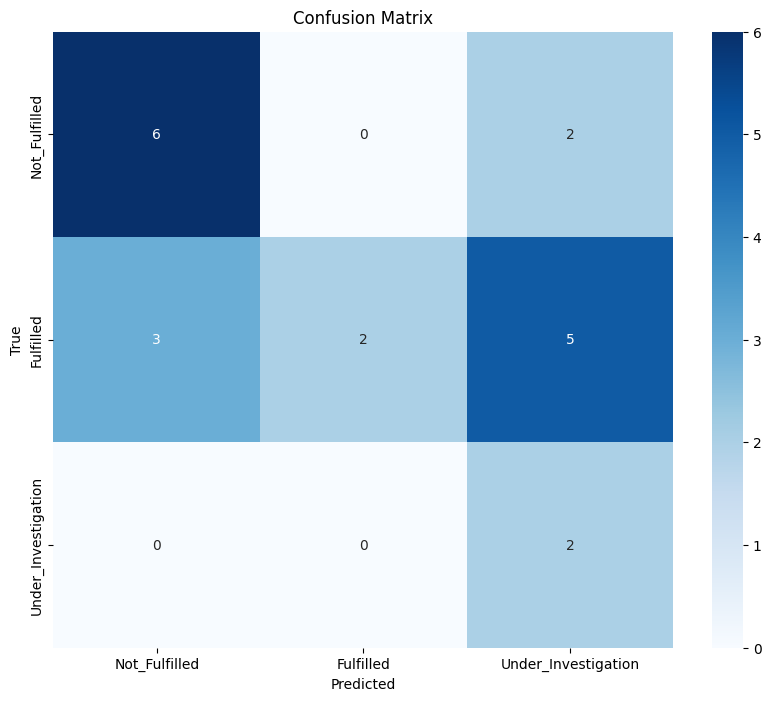


Per-class Accuracy for Zero-Shot Model:
----------------------------------------
Not_Fulfilled            : 0.7500 (6/8)
Fulfilled                : 0.2000 (2/10)
Under_Investigation      : 1.0000 (2/2)

Overall Accuracy: 0.5000

ROC AUC Curve (One vs Rest) for Zero-Shot Model:


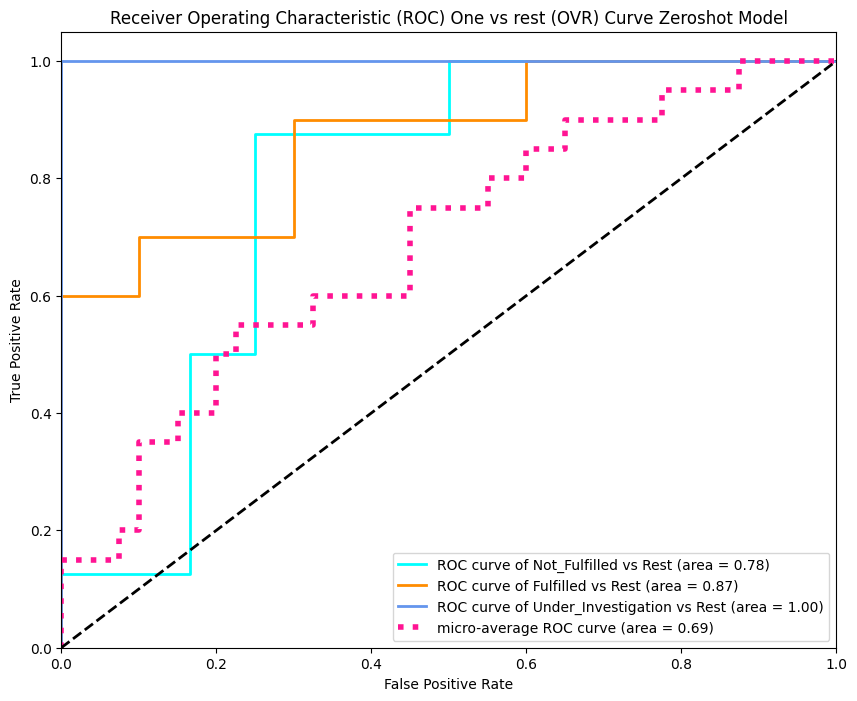


Model ROC-AUC scores:
Not_Fulfilled vs rest: 0.7812
Fulfilled vs rest: 0.8700
Under_Investigation vs rest: 1.0000
Micro-average: 0.6863


In [31]:
# --- 5. UNIVERSAL DATA SPLITTING ---

# Load the polymer data
df_polymer = pd.read_csv(POLYMER_DATA_PATH)

# Create the PyTorch Dataset
property_cols = [col for col in df_polymer.columns if col.startswith('Property_')]
polymer_dataset = PolymerToxicityDataset(df_polymer, 'fingerprints', property_cols, 'Hazard_Criteria_encoded')
sample_features, _ = polymer_dataset[0]
input_dim = sample_features.shape[0]

# First, prepare the full X and y NumPy arrays
X_polymer = np.array([data[0].numpy() for data in polymer_dataset])
y_polymer = np.array([data[1].numpy() for data in polymer_dataset])

# Define the sizes for each set based on the new strategy
n_total = len(X_polymer)
n_test = 20      # 20 samples for the final noble test set
n_finetune = 20  # 20 samples for the initial fine-tuning

# Step 1: Split off the "Noble Test Set"
X_train_pool, X_test, y_train_pool, y_test = train_test_split(
    X_polymer,
    y_polymer,
    test_size=n_test,
    random_state=RANDOM_SEED,
    stratify=y_polymer
)

# Step 2: Split the training pool into a "Fine-Tuning Set" and a "Cross-Validation Set"
# NOTE: We create these so the data is split identically to the other notebooks, but we won't use them here.
X_cv, X_finetune, y_cv, y_finetune = train_test_split(
    X_train_pool,
    y_train_pool,
    test_size=n_finetune,
    random_state=RANDOM_SEED,
    stratify=y_train_pool
)

# --- Verification ---
print("Data has been split into three distinct sets:")
print(f" - Fine-Tuning Set: {len(X_finetune)} samples (IGNORED for Zero-Shot)")
print(f" - Cross-Validation Set: {len(X_cv)} samples (USED  for CV Zero-Shot)")
print(f" - Noble Test Set (Final Evaluation): {len(X_test)} samples (USED for Zero-Shot)")

# --- 6. LOAD MODEL AND EVALUATE ON NOBLE TEST SET ---

# Load Pre-Trained Model
print("\n" + "=" * 60)
print("Loading Pre-trained Base Model...")
print("=" * 60)

# Load hyperparameters to build the model architecture
with open(PARAMS_PATH, 'r') as f:
    best_params = json.load(f)

# Instantiate the model with the loaded architecture
base_model = create_enhanced_model_with_best_params(best_params, input_dim)

# Load the pre-trained weights
base_model.load_state_dict(torch.load(BASE_MODEL_PATH, map_location=device))
base_model.to(device)
print("Pre-trained base model loaded successfully.\n")

# Final Zero-Shot Evaluation on the Noble Test Set
print("\n" + "=" * 60)
print("PERFORMING ZERO-SHOT EVALUATION ON THE NOBLE TEST SET (20 SAMPLES)")
print("=" * 60)

# Create a DataLoader for the noble test set
test_dataset_noble = torch.utils.data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), 
    torch.tensor(y_test, dtype=torch.long)
)
test_loader_noble = DataLoader(test_dataset_noble, batch_size=best_params['batch_size'], shuffle=False)

# Evaluate the final model on the noble test set
final_metrics = evaluate_model(base_model, test_loader_noble, class_names)

# Classification Report
print("\nDetailed Classification Report for Zero-Shot Model:")
print("-" * 60)
print(classification_report(final_metrics['targets'], final_metrics['predictions'], target_names=class_names))

# Confusion Matrix
print("\nConfusion Matrix for Zero-Shot Model:")
cm_zero_shot = confusion_matrix(final_metrics['targets'], final_metrics['predictions'])
plot_confusion_matrix(
    cm_zero_shot, 
    class_names, 
    save_path=os.path.join(RESULTS_DIR, 'zeroshot_model_confusion_matrix.png')
)

# Per-class Accuracy
print("\nPer-class Accuracy for Zero-Shot Model:")
print("-" * 40)
for i, name in enumerate(class_names):
    true_samples_for_class = cm[i].sum()
    if true_samples_for_class > 0:
        class_accuracy = cm[i, i] / true_samples_for_class
        print(f"{name:25s}: {class_accuracy:.4f} ({cm[i, i]}/{true_samples_for_class})")
    else:
        print(f"{name:25s}: No test samples in this class")
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# ROC AUC Curve
print("\nROC AUC Curve (One vs Rest) for Zero-Shot Model:")
plot_roc_curves(final_metrics['targets'], final_metrics['probabilities'], class_names, save_path=os.path.join(RESULTS_DIR, "zeroshot_final_roc_curve.png"))

### 5-Fold Cross-Validation on the CV Set

In [27]:
# --- Load Pre-Trained Model ---
print("\n" + "=" * 60)
print("Loading Pre-trained Base Model...")
with open(PARAMS_PATH, 'r') as f:
    best_params = json.load(f)
base_model = create_enhanced_model_with_best_params(best_params, input_dim)
base_model.load_state_dict(torch.load(BASE_MODEL_PATH, map_location=device))
base_model.to(device)
print("Pre-trained base model loaded successfully.\n")

# --- 5-Fold Cross-Validation on the CV Set (56 samples) ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
summary_metrics = []

print("\n" + "=" * 60)
print("Starting 5-Fold Cross-Validation on the CV Set")
print("=" * 60)

for fold, (_, test_idx) in enumerate(skf.split(X_cv, y_cv)):
    print(f"\nFold {fold + 1}/5")
    print("-" * 30)

    X_test_fold, y_test_fold = X_cv[test_idx], y_cv[test_idx]
    
    print(f"Test samples for this fold: {len(X_test_fold)}")
    
    test_dataset_fold = torch.utils.data.TensorDataset(torch.tensor(X_test_fold, dtype=torch.float32), torch.tensor(y_test_fold, dtype=torch.long))
    test_loader_fold = DataLoader(test_dataset_fold, batch_size=best_params['batch_size'], shuffle=False)
    
    # Evaluate the base model on this fold's test set
    fold_metrics = evaluate_model(base_model, test_loader_fold, class_names)
    
    print(f"Accuracy:  {fold_metrics['accuracy']:.4f}")
    print(f"F1 Score:  {fold_metrics['f1']:.4f}")
    print(f"ROC-AUC:   {fold_metrics['roc_auc']:.4f}")
    summary_metrics.append(fold_metrics)
    
# --- Summary statistics from the 5-Fold CV on the development set ---
print("\n" + "=" * 60)
print("ZERO-SHOT ROBUSTNESS: SUMMARY STATISTICS ACROSS CV FOLDS")
print("=" * 60)

# Extract each metric from the list of dictionaries
accuracies = [m['accuracy'] for m in summary_metrics]
precisions = [m['precision'] for m in summary_metrics]
recalls = [m['recall'] for m in summary_metrics]
f1s = [m['f1'] for m in summary_metrics]
roc_aucs = [m['roc_auc'] for m in summary_metrics]

# Calculate and print the stats
print(f"ACCURACY  : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f} (min: {np.min(accuracies):.4f}, max: {np.max(accuracies):.4f})")
print(f"PRECISION : {np.mean(precisions):.4f} ± {np.std(precisions):.4f} (min: {np.min(precisions):.4f}, max: {np.max(precisions):.4f})")
print(f"RECALL    : {np.mean(recalls):.4f} ± {np.std(recalls):.4f} (min: {np.min(recalls):.4f}, max: {np.max(recalls):.4f})")
print(f"F1        : {np.mean(f1s):.4f} ± {np.std(f1s):.4f} (min: {np.min(f1s):.4f}, max: {np.max(f1s):.4f})")
print(f"ROC_AUC   : {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f} (min: {np.min(roc_aucs):.4f}, max: {np.max(roc_aucs):.4f})")


Loading Pre-trained Base Model...
Pre-trained base model loaded successfully.


Starting 5-Fold Cross-Validation on the CV Set

Fold 1/5
------------------------------
Test samples for this fold: 12


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.5000
F1 Score:  0.4737
ROC-AUC:   0.8856

Fold 2/5
------------------------------
Test samples for this fold: 11


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.6364
F1 Score:  0.6805
ROC-AUC:   0.9198

Fold 3/5
------------------------------
Test samples for this fold: 11


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.4545
F1 Score:  0.5108
ROC-AUC:   0.7976

Fold 4/5
------------------------------
Test samples for this fold: 11


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.5455
F1 Score:  0.6667
ROC-AUC:   nan

Fold 5/5
------------------------------
Test samples for this fold: 11


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy:  0.4545
F1 Score:  0.3609
ROC-AUC:   0.8000

ZERO-SHOT ROBUSTNESS: SUMMARY STATISTICS ACROSS CV FOLDS
ACCURACY  : 0.5182 ± 0.0680 (min: 0.4545, max: 0.6364)
PRECISION : 0.7110 ± 0.2003 (min: 0.3212, max: 0.8864)
RECALL    : 0.5182 ± 0.0680 (min: 0.4545, max: 0.6364)
F1        : 0.5385 ± 0.1209 (min: 0.3609, max: 0.6805)
ROC_AUC   : nan ± nan (min: nan, max: nan)


## 9. Summary and Conclusions

This enhanced notebook has successfully implemented:

### Key Enhancements:
1. **PReLU Activation Function**: Parametric ReLU with learnable negative slope for better gradient flow
2. **Early Stopping**: Prevents overfitting with patience-based stopping and weight restoration
3. **Multiple Activation Functions**: Support for ReLU, PReLU, SiLU, LeakyReLU, ELU, and GELU in Optuna optimization
4. **Comprehensive 5-Fold Cross-Validation**: Detailed metrics, classification reports, and statistical analysis
5. **Data Distribution Visualization**: Bar plots for both Tox21 and monomer datasets
6. **Enhanced ROC Curve Analysis**: Separate functions for DataLoader and raw data inputs
7. **Advanced Optuna Optimization**: Improved pruning, visualization, and parameter importance analysis

### Results:
- The transfer learning approach successfully leverages the Tox21 dataset for polymer toxicity prediction
- PReLU activation and early stopping help improve model performance and prevent overfitting
- Comprehensive cross-validation provides robust evaluation of the few-shot learning approach
- Detailed visualizations and reports enable thorough analysis of model performance

### Next Steps:
- Consider ensemble methods for further performance improvements
- Explore additional data augmentation techniques for the limited polymer dataset
- Implement model interpretability methods to understand feature importance
- Consider focal loss or other advanced techniques for handling class imbalance